## ***SIMULACIÓN***  
Métodos necesarios para la simulación del inventario

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

Inicialización de variables

In [2]:
x_1 = 70 #numero de unidades del producto 1
x_2 = 70 #numero de unidades del producto 2
T_simulacion = 5*24*30
#T_simulacion = 5*30*24 #tiempo transcurrido en la simulacion en horas
Tp = 7*24 #cada cuanto pide (cada semana)
lista = {'tc': 0,  # tiempo en el que ha llegado un cliente
         'tpc': 0, # tiempo en el que se ha comprado un pedido
         'tp': 0}  # tiempo en el que ha llegado un pedido
R = 0 #beneficio esperado
P1 = 1000 #numero de unidades max del producto 1
P2 = 1500 #numero de unidades max del producto 2
Nc = 0 #numero de clientes satisfechos
Nnc = 0 # numero de clientes no satisfechos
t0 = 0 # numero de tiempo que el intervalo esta a cero
C = 0 #coste total por pedidos
H = 0 #coste total por almacenamiento
lambda_poisson = 0.5
demanda = [1, 2, 3, 4] #posibles demandas del producto
probab_1 = [0.3, 0.4, 0.2, 0.1] #probabilidades de demanda del producto 1
probab_2 = [0.2, 0.2, 0.4, 0.2] #probabilidades de demanda del producto 2
r_1 = 2.5 #coste al publico del producto 1
r_2 = 3.5 #coste al publico del producto 2
h = 0.0002 #precio sumado por producto y unidad de tiempo
mu = 48 #tiempo de media que tarda un pedido
sigma = 3.5 #desviacion tipica de lo que tarda un pedido
K = 100 #coste fijo del proveedor
n_descuent_1 = 600 #unidades mayores a estas obtienen descuento en producto 1
p1_1 = 1 # precio si son menos de 600 uds del producto 1
p1_2 = 0.75 # precio si son mas de 600 uds del producto 1
n_descuent_2 = 800
p2_1 = 1.5
p2_2 = 1.25
L = 0 #lo que tarda en llegar el pedido desde que se compra
Lref = 48 #tiempo media de llegada del pedido
lim_penal = 3 #a partir de estas horas de retraso del pedido, penalizacion
penal = 0.0003 # la penalizacion en el precio si llega tarde/pronto 
t_real = 0
var_aux = 0 # instante en el que el almacen se vacia completamnete
ts = 0 #tiempo de simulacion

#Vectores para la representación gráfica de los niveles de inventario de los dos tipos de producto a lo largo del tiempo

tiempos_1 = [0]
niveles_1 = [70]
tiempos_2 = [0]
niveles_2 = [70]

# datos_grafica [producto 1 o 2] [tiempo (0) o nivel(1)] [i]  
datos_grafica = ["",
                 [[0],[70]], # tiempo y nivel producto 1
                 [[0],[70]]  # tiempo y nivel producto 2
                ]

Métodos para la simulación

In [3]:
def rutina_llegada_cliente(ts):
    global H, h, t_real, x_1, x_2, Nc, Nnc, var_aux, R, Y, y_1, y_2
    global r_1, r_2, var_aux, T_simulacion, tiempos_1, tiempos_2
    global niveles_1, niveles_2
  
    #Aumenta el coste de almacenamiento
    H += (ts-t_real)*h*(x_1+x_2)
    t_real = ts
  
    #Generamos demanda del cliente
    demanda_1 = np.random.choice(demanda, 1, p=probab_1)[0]
    demanda_2 = np.random.choice(demanda, 1, p=probab_2)[0]
  
    #Si hay suficiente almacenado, esta satisfecho
    if demanda_1<=x_1 and demanda_2<=x_2 :
        R += demanda_1*r_1 + demanda_2*r_2 #sube el beneficio
        x_1 -= demanda_1   #baja el inventario
        x_2 -= demanda_2
        Nc += 1 #cliente satisfecho
    #Si no hay suficiente almacenado de algun producto, no esta satisfecho
    else:
        Nnc += 1 #cliente no satisfecho
        if demanda_1 <= x_1:
            R += demanda_1*r_1 
            x_1 -= demanda_1
        elif demanda_2 <= x_2:
            R += demanda_2*r_2 
            x_2 -= demanda_2
    
    # Si se ha vaciado del todo (y antes no estaba vacio) guardamos el tiempo actual
    if x_2 == 0 and x_1 == 0 and var_aux == 0 :
        var_aux = t_real
    
    #Generamos el tiempo que tarda en llegar el siguiente cliente
    Y = stats.poisson.rvs(lambda_poisson, size=1)[0] 
  
    # si el cliente llega antes de acabar la simulacion, se simula
    if Y+t_real < T_simulacion:
        lista['tc'] = t_real+Y 

In [4]:
def rutina_llegada_pedido(ts):
    global H, K, h, t_real, C, t0, var_aux, x_1, x_2, y_1, y_2
    global p1_1, p1_2, p2_1, p2_1, penal, var_aux
    global tiempos_1, tiempos_2, niveles_1, niveles_2
  
    #Aumenta el coste de almacenamiento
    H += (ts-t_real)*h*(x_1+x_2)
    t_real = ts
  
    #Aumenta el nivel de inventario
    x_1 += y_1
    x_2 += y_2
  
    #Si son muchas unidades, descuento en el precio
    Ci_1 = K + y_1 * p1_1 if y_1<=n_descuent_1 else K + y_1 * p1_2
    Ci_2 = K + y_2 * p2_1 if y_2<=n_descuent_2 else K + y_2 * p2_2
  
    #Si llega pronto es mas caro, si llega tarde, es mas barato
    if L < Lref-lim_penal:
        C += (Ci_1 + Ci_2) * (1 + penal)
    elif L > Lref+lim_penal:
        C += (Ci_1 + Ci_2) * (1 - penal)
    else:
        C += Ci_1 + Ci_2
  
    #Ya no quedan productos por llegar
    y_1 = 0
    y_2 = 0
  
    # Si estaba vacio el invenario (se vacio en el instante var_aux),
    # aumenta el tiempo que ha estado vacio.
    if var_aux > 0:
        t0 += t_real - var_aux
        var_aux = 0

In [5]:
def rutina_compra_pedido(ts):
    global H, x_1, x_2, t_real, y_1, y_2, h, t_real
    global P1, P2, lista, T_simulacion

    # Aumenta el coste de almacenamiento
    H += (ts-t_real)*h*(x_1+x_2)
    t_real = ts
  
    #Cantidad a pedir es lo que falta para llenar el almacen
    y_1 = P1 - x_1
    y_2 = P2 - x_2

    #Generamos cuanto va a tardar en llegar el pedido
    L = np.random.normal(mu, sigma, 1)[0]

    # actualizamos el tiempo de llegada del pedido y el tiempo de siguiente compra
    if L+t_real < T_simulacion:
        lista['tp'] = t_real + L
    
    if t_real+Tp < T_simulacion:
        lista['tpc'] = t_real + Tp

Rutina para la simulación

In [6]:
def simul_main(periodicidad,nivel_1,nivel_2):
    global x_1, x_2, T_simulacion , Tp, lista, R, P1, P2, Nc, Nnc, t0, C, H
    global lambda_poisson, demanda, probab_1, probab_2, r_1, r_2, h, mu, sigma
    global K, n_descuent_1, p1_1, p1_2, p2_1, p2_2, n_descuent_2, L, Lref
    global lim_penal, penal, treal, var_aux, ts
  
    #Reseteamos las variables
    x_1 = 70 #numero de unidades del producto 1
    x_2 = 70 #numero de unidades del producto 2
    T_simulacion = 5*24*30 #tiempo transcurrido en la simulacion en horas
    Tp = periodicidad #cada cuanto pide (cada semana)
    lista = {'tc': 0,  # tiempo en el que ha llegado un cliente
            'tpc': 0, # tiempo en el que se ha comprado un pedido
            'tp': 0}  # tiempo en el que ha llegado un pedido
    R = 0 #beneficio esperado
    P1 = nivel_1 #numero de unidades max del producto 1
    P2 = nivel_2 #numero de unidades max del producto 2
    Nc = 0 #numero de clientes satisfechos
    Nnc = 0 # numero de clientes no satisfechos
    t0 = 0 # numero de tiempo que el intervalo esta a cero
    C = 0 #coste total por pedidos
    H = 0 #coste total por almacenamiento
    lambda_poisson = 0.5
    demanda = [1, 2, 3, 4] #posibles demandas del producto
    probab_1 = [0.3, 0.4, 0.2, 0.1] #probabilidades de demanda del producto 1
    probab_2 = [0.2, 0.2, 0.4, 0.2] #probabilidades de demanda del producto 2
    r_1 = 2.5 #coste al publico del producto 1
    r_2 = 3.5 #coste al publico del producto 2
    h = 0.0002 #precio sumado por producto y unidad de tiempo
    mu = 48 #tiempo de media que tarda un pedido
    sigma = 3.5 #desviacion tipica de lo que tarda un pedido
    K = 100 #coste fijo del proveedor
    n_descuent_1 = 600 #unidades mayores a estas obtienen descuento en producto 1
    p1_1 = 1 # precio si son menos de 600 uds del producto 1
    p1_2 = 0.75 # precio si son mas de 600 uds del producto 1
    n_descuent_2 = 800
    p2_1 = 1.5
    p2_2 = 1.25
    
    L = 0 #lo que tarda en llegar el pedido desde que se compra
    Lref = 48 #tiempo media de llegada del pedido
    lim_penal = 3 #a partir de estas horas de retraso del pedido, penalizacion
    penal = 0.0003 # la penalizacion en el precio si llega tarde/pronto 
    t_real = 0
    var_aux = 0 # instante en el que el almacen se vacia completamnete
    ts = 0 #tiempo de simulacion
  
    # Iniciamos siumlacion
    ts = 0
    lista['tc'] = 4000
    lista['tp'] = 4000
    lista['tpc'] = Tp
    
    #Generamos el tiempo que tarda en llegar el primer cliente
    Z = stats.poisson.rvs(lambda_poisson, size=1)[0]

    #Si el tiempo si pasa del limite T, la simulación se acaba
    if Z > T_simulacion: return -1
  
    #print('** Llega el primer cliente')
    rutina_llegada_cliente(Z)
  
    #Repetir si siguen llegando clientes o siguen llegando pedidos
    while (lista['tc']!=4000 or lista['tp']!=4000) and ts <= T_simulacion:
    
        #Si el siguiente evento es la llegada de un cliente
        if lista['tc'] <= lista['tpc'] and lista['tc'] <= lista['tp']:
            ts = lista['tc']
            lista['tc'] = 4000
            rutina_llegada_cliente(ts)

        #Si el siguiente evento es la compra de un pedido 
        elif(lista['tpc']<=lista['tc'] and lista['tpc']<=lista['tp']):
            ts = lista['tpc']
            lista['tpc'] = 4000
            rutina_compra_pedido(ts)

        #Si el siguiente evento es una llegada de pedido
        elif(lista['tp']<=lista['tc'] and lista['tp']<=lista['tpc']):
            ts = lista['tp']
            lista['tp'] = 4000
            rutina_llegada_pedido(ts)
      
    benef = R - C - H                #Beneficios
    cl_satisf = Nc / (Nc + Nnc) *100 #Porcentaje de clientes satisfechos
    t0_tot = t0 / T_simulacion       #Tiempo que ha estado el almacen vacio
  
    return benef

## ***RECOCIDO SIMULADO*** 

In [7]:
import random
import math
import matplotlib

In [8]:
def buscando_temperatura(T,initial_state):
    lista_temp = []
    lista_prob = []
 
    while T > 7000:
        neighbor = get_neighbor(initial_state)
        initial_state["benef"] = get_benef(initial_state)
        neighbor["benef"] = get_benef(neighbor)
        benef_diff = neighbor["benef"] - initial_state["benef"]
        prob = math.exp( - abs(benef_diff) / T)
        lista_temp.append(T)
        lista_prob.append(prob)
        T-=10
    grafica('Temperatura inicial','Probabilidad',lista_temp,lista_prob)

In [9]:
def grafica(titulox,tituloy,x,*args):
    for n in args:
        plt.plot(x,n)
    plt.xlabel(titulox)
    plt.ylabel(tituloy)
    plt.show()

def grafica3(titulox, tituloy, x, niv1, niv2, periodo):
    plt.plot(x,niv1,label='Nivel producto 1')
    plt.plot(x,niv2,label='Nivel producto 2')
    plt.xlabel(titulox)
    plt.ylabel('Nivel máximo de inventario')
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(x,periodo)
    plt.xlabel(titulox)
    plt.ylabel('Periodo de realización de pedido')
    plt.show()

In [25]:
def recocido_simulado(initial_state):
    # HIPERPARAMETERS
    alpha = 0.95 #Ritmo de decrecimiento de la temperatura
    initial_temp = 8000
    max_it_sin_cambio = 300
    max_L = 10
    
    it_sin_cambio = 0 # Numero de iteraciones sin cambio, max 10
    L = 0 #Num de iteraciones donde mantenemos la temperatura
    iteraciones = 1 #Contador de iteraciones
    
    #Variables graficas
    lista_benef = []
    lista_temp = []
    lista_prob = []
    lista_sol = []
    lista_niv_1 = []
    lista_niv_2 =[]
    lista_periodo = []

    # Primera iteracion
    current_temp = initial_temp
    current_state = initial_state
    current_state["benef"] = get_benef(current_state)
    best_state = current_state
    
    while it_sin_cambio < max_it_sin_cambio:
        # Comprobar si el vecino es mejor
        neighbor = get_neighbor(current_state)
        neighbor["benef"] = get_benef(neighbor)

        benef_diff = neighbor["benef"] - current_state["benef"]
        prob = math.exp(-abs(benef_diff) / current_temp)

        # Si es mejor, aceptamos vecino
        # Si es peor, aceptamos si p>u
        if benef_diff > 0 or random.uniform(0, 1) < prob:
            current_state = neighbor
                        
        print("It."+str(iteraciones)+
                 "\tTemp.: "+str(int(current_temp))+
                    "\tProb.: "+str(prob)+
                    "\tBeneficio: "+str(current_state["benef"])+
                    "\tParametros: "+str(current_state["periodicidad"])+", "+
                                                        str(current_state["nivel_1"])+", "+
                                                        str(current_state["nivel_2"]))

        
        
        lista_benef.append(best_state['benef'])
        lista_temp.append(current_temp)
        lista_prob.append(prob)
        lista_sol.append(current_state['benef'])
        lista_niv_1.append(current_state['nivel_1'])
        lista_niv_2.append(current_state['nivel_2'])
        lista_periodo.append(current_state['periodicidad'])

        # Bajamos temperatura
        if L==max_L:
            current_temp = current_temp * alpha
            L=0
        
        iteraciones += 1
        L += 1
        it_sin_cambio +=1 
        
        if best_state["benef"] < current_state["benef"]:
            best_state = current_state
            it_sin_cambio = 0
        
    grafica('Iteraciones','Mejor Solucion',range(1,iteraciones),lista_benef)
    grafica('Iteraciones','Temperatura',range(1,iteraciones),lista_temp)
    grafica('Iteraciones','Funcion fitness',range(1,iteraciones),lista_sol)
    grafica('Iteraciones','Factores de decision',range(1,iteraciones),lista_niv_1,lista_niv_2,lista_periodo)
    grafica3('Iteraciones','Factores de decision',range(1,iteraciones),lista_niv_1,lista_niv_2,lista_periodo)
    grafica('Iteraciones','Probabilidades',range(1,iteraciones),lista_prob)
    return best_state

In [17]:
def get_benef(state):
        return simul_main(state["periodicidad"], state["nivel_1"], state["nivel_2"])

In [18]:
def get_neighbor(state):
        """Returns neighbors of the argument state for your solution."""
        new_periodicidad = state["periodicidad"] + np.random.uniform(-1,1)
        new_nivel_1 = state["nivel_1"] + random.randint(-3,3)
        new_nivel_2 = state["nivel_2"] + random.randint(-3,3)

        neighbor = {'periodicidad':new_periodicidad ,    
                                            'nivel_1': new_nivel_1,
                                            'nivel_2': new_nivel_2 }

        return neighbor

It.1	Temp.: 7500	Prob.: 0.8424976317508742	Beneficio: 55694.282470182094	Parametros: 168.9221082653694, 1003, 1499
It.2	Temp.: 7500	Prob.: 0.6963385707981409	Beneficio: 58408.67710491534	Parametros: 168.75128699227062, 1001, 1497
It.3	Temp.: 7500	Prob.: 0.6954029186663936	Beneficio: 55684.198137569394	Parametros: 168.37389186038317, 999, 1499
It.4	Temp.: 7500	Prob.: 0.9938593310919512	Beneficio: 55638.001134896935	Parametros: 167.3836090000732, 1002, 1499
It.5	Temp.: 7500	Prob.: 0.8905514734960197	Beneficio: 56507.35894745473	Parametros: 167.38513770031895, 1000, 1498
It.6	Temp.: 7500	Prob.: 0.9857485528375979	Beneficio: 56399.704140144306	Parametros: 168.28805733795934, 1003, 1499
It.7	Temp.: 7500	Prob.: 0.955857604005718	Beneficio: 56738.301591216834	Parametros: 168.1512872734196, 1001, 1496
It.8	Temp.: 7500	Prob.: 0.8968218130279574	Beneficio: 55921.56595866802	Parametros: 168.05906298965138, 1003, 1498
It.9	Temp.: 7500	Prob.: 0.9453925679415465	Beneficio: 55500.40329412932	Parametr

It.72	Temp.: 3587	Prob.: 0.5906699236765162	Beneficio: 58716.07157454589	Parametros: 164.4113569984331, 1022, 1468
It.73	Temp.: 3587	Prob.: 0.48212689440371037	Beneficio: 58716.07157454589	Parametros: 164.4113569984331, 1022, 1468
It.74	Temp.: 3587	Prob.: 0.3403884186777162	Beneficio: 58716.07157454589	Parametros: 164.4113569984331, 1022, 1468
It.75	Temp.: 3587	Prob.: 0.31943395373192374	Beneficio: 58716.07157454589	Parametros: 164.4113569984331, 1022, 1468
It.76	Temp.: 3587	Prob.: 0.5383679259657029	Beneficio: 60937.32928220527	Parametros: 164.46910356236813, 1023, 1467
It.77	Temp.: 3587	Prob.: 0.7734387168139125	Beneficio: 60937.32928220527	Parametros: 164.46910356236813, 1023, 1467
It.78	Temp.: 3587	Prob.: 0.4941085774405255	Beneficio: 58408.334446573885	Parametros: 164.23582918899268, 1024, 1466
It.79	Temp.: 3587	Prob.: 0.6383397246209594	Beneficio: 56798.083409427265	Parametros: 163.2623828769471, 1022, 1463
It.80	Temp.: 3587	Prob.: 0.5680123066169325	Beneficio: 58827.062601571066

It.143	Temp.: 1715	Prob.: 0.776023966647143	Beneficio: 59248.65877530062	Parametros: 163.24527806025225, 1033, 1473
It.144	Temp.: 1715	Prob.: 0.159529080957767	Beneficio: 59248.65877530062	Parametros: 163.24527806025225, 1033, 1473
It.145	Temp.: 1715	Prob.: 0.7177313892638096	Beneficio: 59817.707359785956	Parametros: 162.66895760849894, 1030, 1473
It.146	Temp.: 1715	Prob.: 0.17166795827987932	Beneficio: 59817.707359785956	Parametros: 162.66895760849894, 1030, 1473
It.147	Temp.: 1715	Prob.: 0.3625549385889198	Beneficio: 59817.707359785956	Parametros: 162.66895760849894, 1030, 1473
It.148	Temp.: 1715	Prob.: 0.3182983773432221	Beneficio: 57853.56422234609	Parametros: 163.48798335922308, 1027, 1470
It.149	Temp.: 1715	Prob.: 0.8612051098302597	Beneficio: 57597.191020824765	Parametros: 164.2578029953817, 1027, 1469
It.150	Temp.: 1715	Prob.: 0.3353218480982068	Beneficio: 59471.94038975045	Parametros: 164.5681483381011, 1028, 1470
It.151	Temp.: 1715	Prob.: 0.11241765038744209	Beneficio: 59471.

It.213	Temp.: 820	Prob.: 0.24250422395137267	Beneficio: 59200.36368612838	Parametros: 162.3431553026658, 1045, 1470
It.214	Temp.: 820	Prob.: 0.14286266664983258	Beneficio: 59200.36368612838	Parametros: 162.3431553026658, 1045, 1470
It.215	Temp.: 820	Prob.: 0.06272300284830488	Beneficio: 59200.36368612838	Parametros: 162.3431553026658, 1045, 1470
It.216	Temp.: 820	Prob.: 0.5384557944492424	Beneficio: 59200.36368612838	Parametros: 162.3431553026658, 1045, 1470
It.217	Temp.: 820	Prob.: 0.03989370587684588	Beneficio: 59200.36368612838	Parametros: 162.3431553026658, 1045, 1470
It.218	Temp.: 820	Prob.: 0.025714058648874022	Beneficio: 59200.36368612838	Parametros: 162.3431553026658, 1045, 1470
It.219	Temp.: 820	Prob.: 0.09224343742824093	Beneficio: 59200.36368612838	Parametros: 162.3431553026658, 1045, 1470
It.220	Temp.: 820	Prob.: 0.052355524835852214	Beneficio: 59200.36368612838	Parametros: 162.3431553026658, 1045, 1470
It.221	Temp.: 820	Prob.: 0.07619673508479917	Beneficio: 59200.363686128

It.283	Temp.: 392	Prob.: 7.854019302214852e-05	Beneficio: 61305.16354092877	Parametros: 161.83529996595848, 1051, 1464
It.284	Temp.: 392	Prob.: 0.0008492178419049388	Beneficio: 61305.16354092877	Parametros: 161.83529996595848, 1051, 1464
It.285	Temp.: 392	Prob.: 0.026582794649934214	Beneficio: 61305.16354092877	Parametros: 161.83529996595848, 1051, 1464
It.286	Temp.: 392	Prob.: 7.539977018979768e-07	Beneficio: 61305.16354092877	Parametros: 161.83529996595848, 1051, 1464
It.287	Temp.: 392	Prob.: 1.4169273439746942e-05	Beneficio: 61305.16354092877	Parametros: 161.83529996595848, 1051, 1464
It.288	Temp.: 392	Prob.: 1.7104751977125793e-06	Beneficio: 61305.16354092877	Parametros: 161.83529996595848, 1051, 1464
It.289	Temp.: 392	Prob.: 9.117727196342621e-05	Beneficio: 61305.16354092877	Parametros: 161.83529996595848, 1051, 1464
It.290	Temp.: 392	Prob.: 1.2192128827655488e-05	Beneficio: 61305.16354092877	Parametros: 161.83529996595848, 1051, 1464
It.291	Temp.: 392	Prob.: 0.0003757745732182879

It.352	Temp.: 187	Prob.: 6.583045772624812e-05	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.353	Temp.: 187	Prob.: 0.0017452901611660345	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.354	Temp.: 187	Prob.: 0.0014857079278003745	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.355	Temp.: 187	Prob.: 2.8455783644692906e-10	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.356	Temp.: 187	Prob.: 5.942303196094105e-16	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.357	Temp.: 187	Prob.: 1.8961324933239278e-05	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.358	Temp.: 187	Prob.: 8.625804801884855e-06	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.359	Temp.: 187	Prob.: 6.498360619449616e-07	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.360	Temp.: 187	Prob.: 4.386212896014838e-10

It.421	Temp.: 99	Prob.: 3.085372163878376e-13	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.422	Temp.: 89	Prob.: 5.181079014287141e-20	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.423	Temp.: 89	Prob.: 1.9702176943620074e-05	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.424	Temp.: 89	Prob.: 1.7489394069784987e-09	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.425	Temp.: 89	Prob.: 3.166073363210256e-07	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.426	Temp.: 89	Prob.: 5.919399240091445e-05	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.427	Temp.: 89	Prob.: 0.014993273124315393	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.428	Temp.: 89	Prob.: 1.86889382048308e-05	Beneficio: 60575.233008843505	Parametros: 162.4148045152953, 1053, 1467
It.429	Temp.: 89	Prob.: 1.4424838888159122e-25	Beneficio

It.491	Temp.: 47	Prob.: 9.70232262470322e-20	Beneficio: 60573.916797932645	Parametros: 162.21830585461342, 1054, 1469
It.492	Temp.: 42	Prob.: 7.875156329586762e-67	Beneficio: 60573.916797932645	Parametros: 162.21830585461342, 1054, 1469
It.493	Temp.: 42	Prob.: 1.020609647299641e-31	Beneficio: 60573.916797932645	Parametros: 162.21830585461342, 1054, 1469
It.494	Temp.: 42	Prob.: 2.8590761112166317e-18	Beneficio: 60573.916797932645	Parametros: 162.21830585461342, 1054, 1469
It.495	Temp.: 42	Prob.: 1.0602574434019024e-19	Beneficio: 60573.916797932645	Parametros: 162.21830585461342, 1054, 1469
It.496	Temp.: 42	Prob.: 2.6923306519416926e-21	Beneficio: 60573.916797932645	Parametros: 162.21830585461342, 1054, 1469
It.497	Temp.: 42	Prob.: 3.792040742470622e-55	Beneficio: 60573.916797932645	Parametros: 162.21830585461342, 1054, 1469
It.498	Temp.: 42	Prob.: 5.694381263858864e-08	Beneficio: 60573.916797932645	Parametros: 162.21830585461342, 1054, 1469
It.499	Temp.: 42	Prob.: 1.9531216197924717e-11

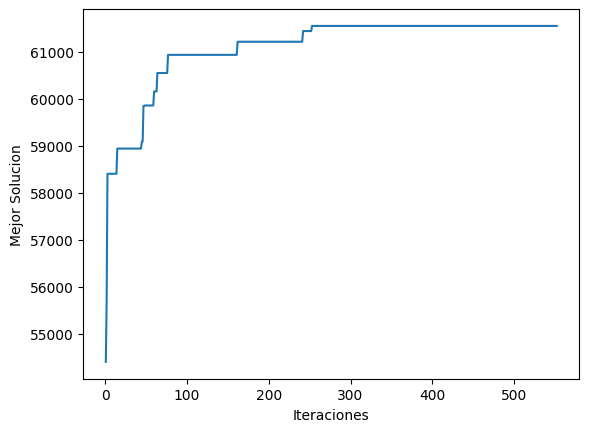

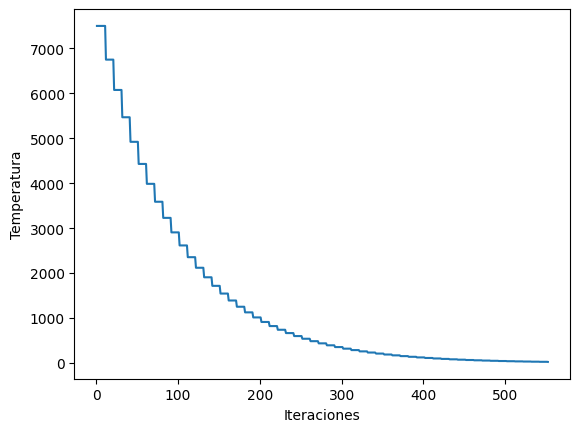

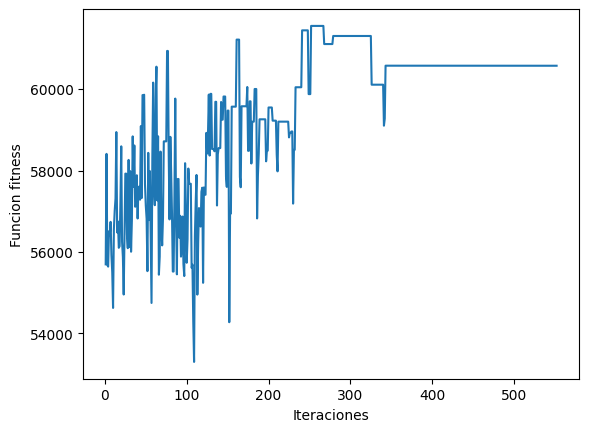

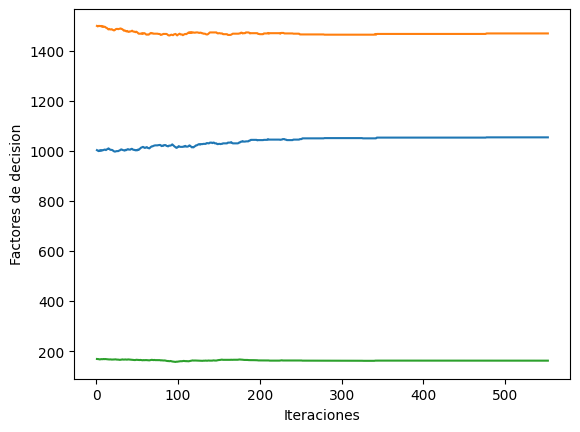

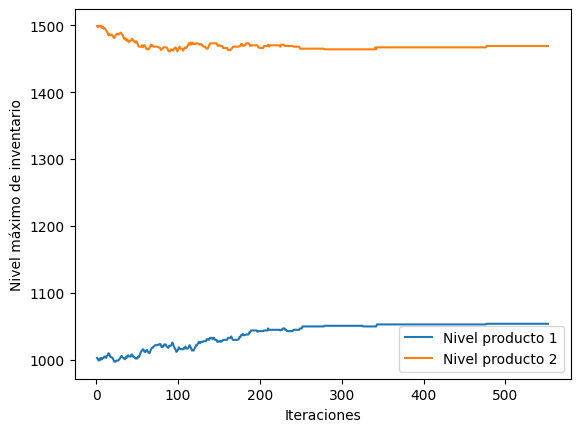

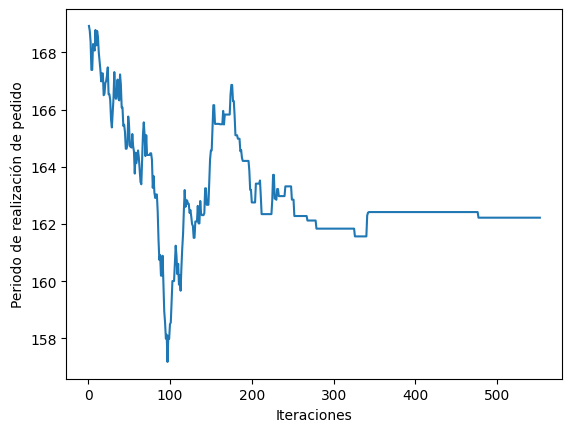

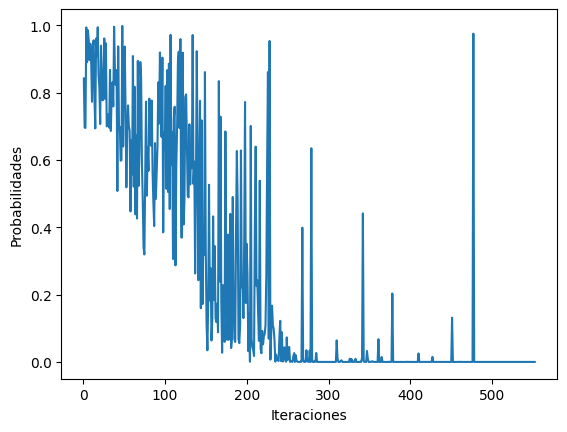

{'periodicidad': 162.27650574139597,
 'nivel_1': 1050,
 'nivel_2': 1465,
 'benef': 61552.39571640047}

In [24]:
initial_state = {'periodicidad': 168, #168 h = 5 días   
                      'nivel_1': 1000,
                      'nivel_2': 1500 }

recocido_simulado(initial_state)

initial_state = {'periodicidad':168 ,  
                      'nivel_1': 1500,
                      'nivel_2': 1000 }
#buscando_temperatura(8000, initial_state)

In [15]:
iteraciones=3
lista_niv_1 = [1000,1010,1020]
lista_niv_2 = [1500,1510,1520]
lista_periodo = [120, 125, 112]

#grafica3('Iteraciones','Factores de decision',range(iteraciones),lista_niv_1,lista_niv_2,lista_periodo)